# Description

We are going to drive the networks with a piece-wise constant input signal and compute the memory capacity, as before. However, instead of a simple rate-based encoding as an inhomogeneous Poisson process, the input signal will be a current injected into an **encoding layer** composed of LIF neurons, which then connect to the main circuit.

### Note: 
This example is more verbose and contains code that is otherwise available as helper functions.

In [29]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel
from scipy import sparse

In [30]:
def get_sparse_matrix(rows,cols,probability,seed):
    # Set the random seed for reproducibility
    rng = np.random.default_rng(seed)
    # Generate a random sparse matrix with values 0 or 1
    sparse_matrix = sparse.random(rows, cols, density=probability, format='csr', random_state=rng, data_rvs=lambda s: rng.integers(1, 2, size=s))
    # Convert the sparse matrix to a dense format
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix

In [31]:
seed = 1
np.random.seed(seed)

# Global settings

In [32]:
T = 100  # total number of time steps (input values)
dt = 0.1  # simulation resolution
num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,
    'local_num_threads': num_threads
})


Oct 23 09:55:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


# Input signal
We are going to drive the networks with a piece-wise constant input signal.

In [33]:
# Input parameters
u_range = [0., 1.]
duration = 20. # [ms]

a) Generate input timeseries - uniform i.i.d. amplitudes

In [34]:
u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)

b) Convert $u$ into a piece-wise constant continuous input signal that will be given as input to the encoders

In [36]:
input_times = np.arange(dt, T*duration, duration)

Now, $u$ specifies the amplitudes and `input_times` specifies the onsets and offsets (used by the step current generator). This piece-wise constant input is the signal that will drive the system $x(t)$.

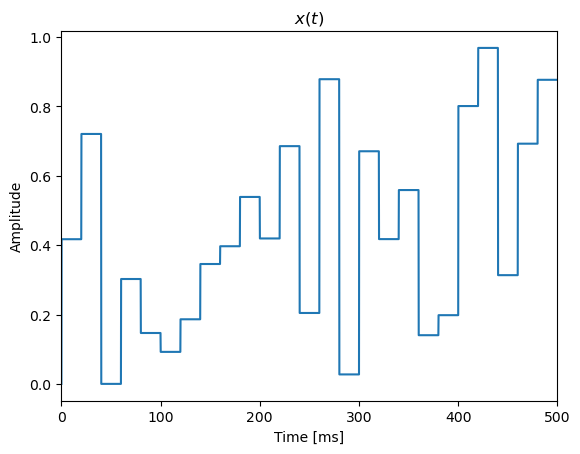

In [37]:
time_vector = np.arange(0., T*duration, dt)
signal = np.zeros_like(time_vector)
for tt in range(len(input_times)-1):
	signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

# visualize input signal
fig, ax = pl.subplots()
ax.plot(time_vector[:5000], signal[:5000])
ax.set_xlim([0, 500])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$x(t)$')
pl.show()

# Encoding Layer
In this section, we are going to create a simple encoding layer, composed of a population of unconnected, passively stimulated neurons. These neurons are driven by the input signal specified before.

The continuous input signal $x(t)$ is converted to an input current $I_{in}(t)$ delivered to a population of spiking neurons. We randomize the tuning of this population, so that each neuron receives a slightly different "version" of the input signal, i.e.:

\begin{equation}
I_{in}(t) = <x(t)^{T}e> + \beta 
\end{equation}

where $e$ specifies the tuning and $\beta$ is a fixed bias current.

In [38]:
# Parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

It is also important to randomize the initial states of the neurons as well as their firing thresholds (to introduce variability in the responses)

In [39]:
# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

In [40]:
enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})

Now we create the input current generator and set the stimulus tuning and neuron parameters

In [41]:
step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(u)))
for n in range(nEnc):
	amplitudes[n, :] = u * tuning[n]
	enc_layer[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
	step_generator[n].set({'amplitude_times': input_times, 'amplitude_values': amplitudes[n]})
	nest.Connect(step_generator[n], enc_layer[n])

Setup the recording devices (for now, we'll only record spikes, but later we can try to explore reading the $V_{m}$ directly)

In [42]:
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)

# Processing Layer
The encoding layer is now fully specified, so the next step is to create the main network. For this example, we will use the standard balanced random network.

In [43]:
# #### PARAMETERS ###
# # network parameters
# gamma = 0.25               # relative number of inhibitory connections
# NE = 1000                  # number of excitatory neurons (10.000 in [1])
# NI = int(gamma * NE)       # number of inhibitory neurons
# CE = 200                  # indegree from excitatory neurons
# CI = int(gamma * CE)       # indegree from inhibitory neurons

# # synapse parameters
# w = 0.1                    # excitatory synaptic weight (mV)
# g = 5.                     # relative inhibitory to excitatory synaptic weight
# d = 1.5                    # synaptic transmission delay (ms)

# # neuron paramters
# neuron_params = {
#     'C_m': 1.0,            # membrane capacity (pF)
#     'E_L': 0.,             # resting membrane potential (mV)
#     'I_e': 0.,             # external input current (pA)
#     'V_m': 0.,             # membrane potential (mV)
#     'V_reset': 10.,        # reset membrane potential after a spike (mV)
#     'V_th': 20.,           # spike threshold (mV)
#     't_ref': 2.0,          # refractory period (ms)
#     'tau_m': 20.,          # membrane time constant (ms)
# }

In [44]:
# network parameters-----------
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
c_factor=1
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)  
Ntotal=NE+NI

# synapse parameters----------
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)
# Define W matrix
w = 0.1 # excitatory synaptic weight (mV)
w *= np.sqrt(10)
n_clusters = 12
# wc = [w *i for i in range(1,(n_clusters+1)*2,2)]
w_factor = 1 # scaling clusters w
wc = [w*w_factor]*n_clusters
w_ex = np.full((NE,NE),w,dtype=np.float64)
nn_c = int(NE/n_clusters)# number of units per cluster
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
w_i = -w*g
w_sparse = get_sparse_matrix(rows=w_ex.shape[0],cols=w_ex.shape[1],probability=0.1,seed=seed)
w_sparse = w_ex*w_sparse

# neuron paramters----------------
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}
params = {'g':g, 
          'eta':1.0,#set external rate above threshold, 
          'w':w,
          'w_e':w_sparse,
          'w_i':w_i,
          'neuron_params':neuron_params,    
          'NE':NE,
          'NI':NI,
          'CE':int(c_factor*CE),
          'CI':int(c_factor*CI), 
          'NrE':NE, 
          'NrI':NI, 
          'rec_start':0, 
          'rec_stop':3050,
}

In [45]:
num_ex = NE  # number of excitatory neurons
num_in = NI  # number of inhibitory neurons
c_ex = CE  # number of excitatory connections
c_in = CI  # number of inhibitory connections
w_e = w_sparse  # excitatory weight
w_i = w_i  # inhibitory weight
w = w
n_rec_ex = NE # number of recorded excitatory neurons, both excitatory and inhibitory
n_rec_in = NI

## Create neurons and devices

In [46]:
# set default parameters for neurons and create neurons
neurons_ex = nest.Create('iaf_psc_delta', num_ex, params=neuron_params)
neurons_in = nest.Create('iaf_psc_delta', num_in, params=neuron_params)
neurons = neurons_ex + neurons_in
# create spike detectors
recorder_ex = nest.Create('spike_recorder')

## Connect network and devices

In [47]:
for i_row in range(num_ex):
    # select non-zero weights
    nonzero = w_e != 0
    nonzero_row = nonzero[i_row]
    nest.Connect(neurons_ex[i_row], neurons_ex[nonzero_row],
                conn_spec = {'rule': 'all_to_all'},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w_e[i_row][nonzero_row].reshape((-1,1))})      
nest.Connect(neurons_ex, neurons_in,
                conn_spec = {'rule': 'fixed_indegree',
                            'indegree': c_ex},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w})
nest.Connect(neurons_in, neurons,
                conn_spec = {'rule': 'fixed_indegree',
                            'indegree': c_in},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w_i})
# spike detector
nest.Connect(neurons_ex, recorder_ex)

## Connect encoding layer to main circuit
For this example, we will use a normal excitatory synapse to connect the encoders to both E and I neurons

In [48]:
nest.Connect(enc_layer, neurons_ex,conn_spec = {'rule': 'fixed_indegree',
                            'indegree': c_ex},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w})
nest.Connect(enc_layer, neurons_in,conn_spec = {'rule': 'fixed_indegree',
                            'indegree': c_ex},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w})

# Simulate and analyse

In [49]:
nest.Simulate(T*duration)


Oct 23 09:55:42 NodeManager::prepare_nodes [Info]: 
    Preparing 5766 nodes for simulation.

Oct 23 09:55:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5766
    Simulation time (ms): 2000
    Number of OpenMP threads: 8
    Not using MPI

Oct 23 09:55:45 SimulationManager::run [Info]: 
    Simulation finished.


In order to evaluate the capacity, we need a continuous state variable. This can be done either by recording the $V_{m}$ and using it directly, or low-pass filtering the recorded spikes (estimate the instantaneous rates). In this example, we use the later case. Note that this implementation is very time-consuming so for later examples, we used the $V_{m}$ instead. These continuous population activity states are stored in the corresponding matrices, $A_{enc}$ and $A_{proc}$:

In [50]:
filter_tau = 20. # [ms]

enc_activity = enc_spks.events
enc_states = filter_spikes_parallel(enc_activity['times'], enc_activity['senders'], nEnc, t_start=0., 
                                    t_stop=T*duration, dt=dt, tau=filter_tau, n_processes=num_threads)


e_activity = recorder_ex.events
# e_states = filter_spikes(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
e_states = filter_spikes_parallel(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, 
                                  dt=dt, tau=filter_tau, n_processes=num_threads)

Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


# Decoding
If the input-driven dynamics contains enough information, we should be able to reconstruct some target signal.. For this purpose, we will use standard linear regression (see functions). If the state of the circuit (be it the encoding layer or the main processing layer is stored in a matrix $A$ and the target signal to reconstruct is $y$, we can estimate the optimal linear projection as:
\begin{equation}
D = \left( A^{T}A\right)^{-1} A^{T}Y
\end{equation}

In the simplest case, we want to reconstruct the original signal, i.e. $y(t)=x(t)$. 

The circuit's capacity to reconstruct $y(t)=f(x(t))$ by linearly combining the population responses is given by:
\begin{equation}
\mathrm{C}[\mathrm{A}, \mathrm{y}]=\frac{\left(A^{T} A\right)^{-1} A y}{\|y\|^{2}}
\end{equation}

where the target function $y(t)$ can be any arbitrary function of the input, i.e. $y(t)=f(x(t))$.

We begin by evaluating how well how well the input signal $x(t)$ is encoded in the activity of the encoding layer $A_{enc}(t)$ and how this is transferred to the main processing circuit $A_{proc}(t)$.

In [51]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=0.6514742492708002, MSE=0.030966077573878384
Main Circuit: 
	- Capacity=0.08336658645321578, MSE=0.20625901150541404


Now, let's visualize the results

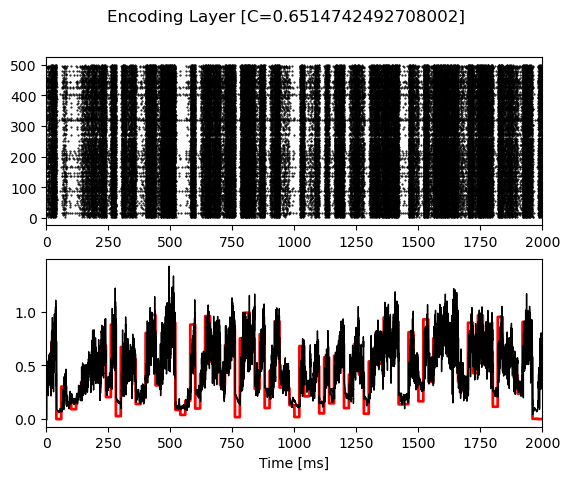

In [52]:
fig = pl.figure()
fig.suptitle('Encoding Layer [C={0}]'.format(str(enc_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(enc_activity['times'], enc_activity['senders'], '.k', markersize=1)
ax11.set_xlim([0., T*duration])
ax12.plot(time_vector, signal, 'r', linewidth=2)
ax12.plot(time_vector, enc_estimate, 'k', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

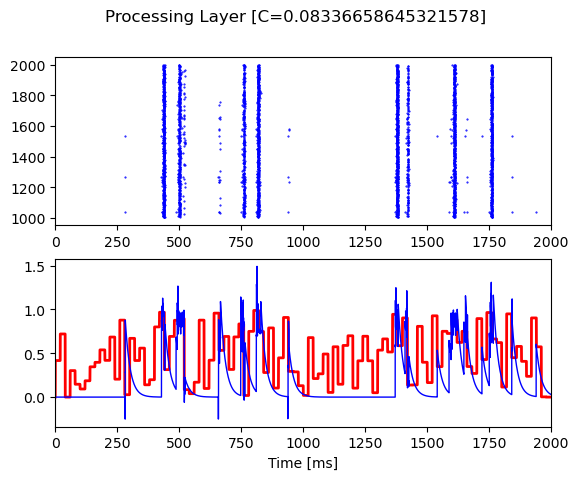

In [53]:
fig = pl.figure()
fig.suptitle('Processing Layer [C={0}]'.format(str(circ_capacity)))
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(e_activity['times'], e_activity['senders'], '.b', markersize=1)
ax11.set_xlim([0., T*duration])
ax12.plot(time_vector, signal, 'r', linewidth=2)
ax12.plot(time_vector, circ_estimate, 'b', linewidth=1)
ax12.set_xlabel(r'Time [ms]')
pl.show()

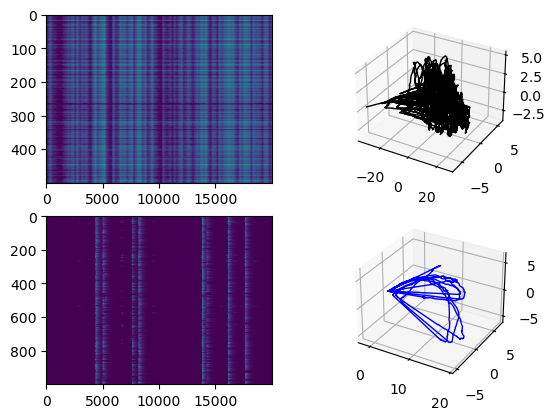

In [54]:
fig = pl.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(enc_states, aspect='auto')
ax2 = fig.add_subplot(222, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(enc_states)[0])
X_enc = pca_fit_enc.fit_transform(enc_states.T)
ax2.plot(X_enc[:, 0], X_enc[:, 1], X_enc[:, 2], color='k', lw=1)
ax3 = fig.add_subplot(223)
ax3.imshow(e_states, aspect='auto')
ax4 = fig.add_subplot(224, projection='3d')
pca_fit_enc = PCA(n_components=np.shape(e_states)[0])
X_cir = pca_fit_enc.fit_transform(e_states.T)
ax4.plot(X_cir[:, 0], X_cir[:, 1], X_cir[:, 2], color='b', lw=1)
pl.show()

# Memory capacity
So far, we have measured the ability to reconstruct the input signal $x(t)$, using the population responses $A(t)=G\left[x(t), a(t)\right]$. The complexity of the nonlinear functional $G$, determined by the neuronal dynamics and synaptic interactions may allow the circuit to retain information about the input for some time (fading memory). So, now we evaluate the circuit's memory capacity, by determining the ability to use the current population state $A(t)$ to reconstruct the input, at various time lags, i.e. we set the target functions to be the original input shifted in time. The idea being that if the circuit has memory, the present state at any given time $t$ should contain information about the input that is driving it $x(t)$, but also about past history of the input (fading memory), i.e. $x(t-\tau_{\mathrm{lag}})$, for $\tau_{\mathrm{lag}} \in [0, \tau^{\mathrm{max}}_{\mathrm{lag}}]$.

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.6514742492708002, MSE=0.030966077573878384
Main Circuit: 
	- Capacity=0.08336658645321578, MSE=0.20625901150541404
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.7344174100561893, MSE=0.023418434741282003
Main Circuit: 
	- Capacity=0.24195624647302258, MSE=0.16265389530304117
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.6072313524090173, MSE=0.0343261386509725
Main Circuit: 
	- Capacity=0.3666439485420666, MSE=0.13616285445846815
Lag = 30.0 ms
Encoding Layer: 
	- Capacity=0.3197543332435026, MSE=0.05894744994473588
Main Circuit: 
	- Capacity=0.23398703592841724, MSE=0.16126856663489564
Lag = 40.0 ms
Encoding Layer: 
	- Capacity=0.2853503244702023, MSE=0.061421414485793406
Main Circuit: 
	- Capacity=0.13749776247112971, MSE=0.18727131769772257
Lag = 50.0 ms
Encoding Layer: 
	- Capacity=0.24786277507802543, MSE=0.06497149134228221
Main Circuit: 
	- Capacity=0.09570059185588958, MSE=0.19979477784402516
Lag = 60.0 ms
Encoding Layer: 
	- Capacity=0.

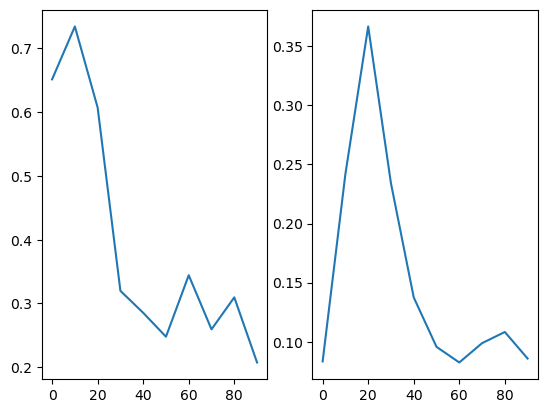

Total capacity (encoder): 39.66729163539928 ms
Total capacity (processor): 15.344852366377669 ms


In [55]:
max_lag = 100.  # [ms] in this example
step_lag = 10.  # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)
indices = [np.where(idx == time_vector)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):

	# shift the target signal
	if idx > 0:
		shifted_signal = signal[:-idx]
	else:
		shifted_signal = signal

	# shift the population states
	enc_st = enc_states[:, idx:]
	circ_st = e_states[:, idx:]

	# compute capacity
	enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
	circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)

	print("Lag = {0} ms".format(str(lag)))
	print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
	print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

	encoder_capacity.append(enc_capacity)
	circuit_capacity.append(circ_capacity)

fig = pl.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_lags, encoder_capacity)
ax2.plot(time_lags, circuit_capacity)

pl.show()

print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))